In [1]:
import pandas as pd
import numpy as np
import h5py
from datetime import datetime, timedelta
import sys

from matplotlib.colors import TwoSlopeNorm, LogNorm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

import geopandas as gpd

In [2]:
# Path to your shapefile
hurricane = "Helene"
storm_path = "../data/storm_track/helene_storm_track.shp"

# Read the shapefile
gdf_helene = gpd.read_file(storm_path)

In [3]:
gdf_helene.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
gdf = gpd.read_file('../data/county_geo/tl_2023_us_county/tl_2023_us_county.shp')
gdf['GEOID'] = gdf['GEOID'].astype(int)

In [5]:
projected_crs =  "EPSG:5070" # Geodetic System 
##"EPSG:5070"  # USA Contiguous Albers Equal Area, this transforms the coordinates to 2d plane
storm_track = gdf_helene.to_crs(projected_crs)
county_centers = gdf.to_crs(projected_crs)

In [6]:
state_fp = pd.read_csv('state_fp.csv')
state_codes = state_fp['State (FIPS)'].unique()
gdf_states = county_centers[county_centers['STATEFP'].astype(int).isin(state_codes)]
SE_states = ['01','05','12','13','21','22','28','37','45','47','51','54','18','17','29','39']
gdf_SE = gdf_states[gdf_states['STATEFP'].isin(SE_states)].copy()

[]

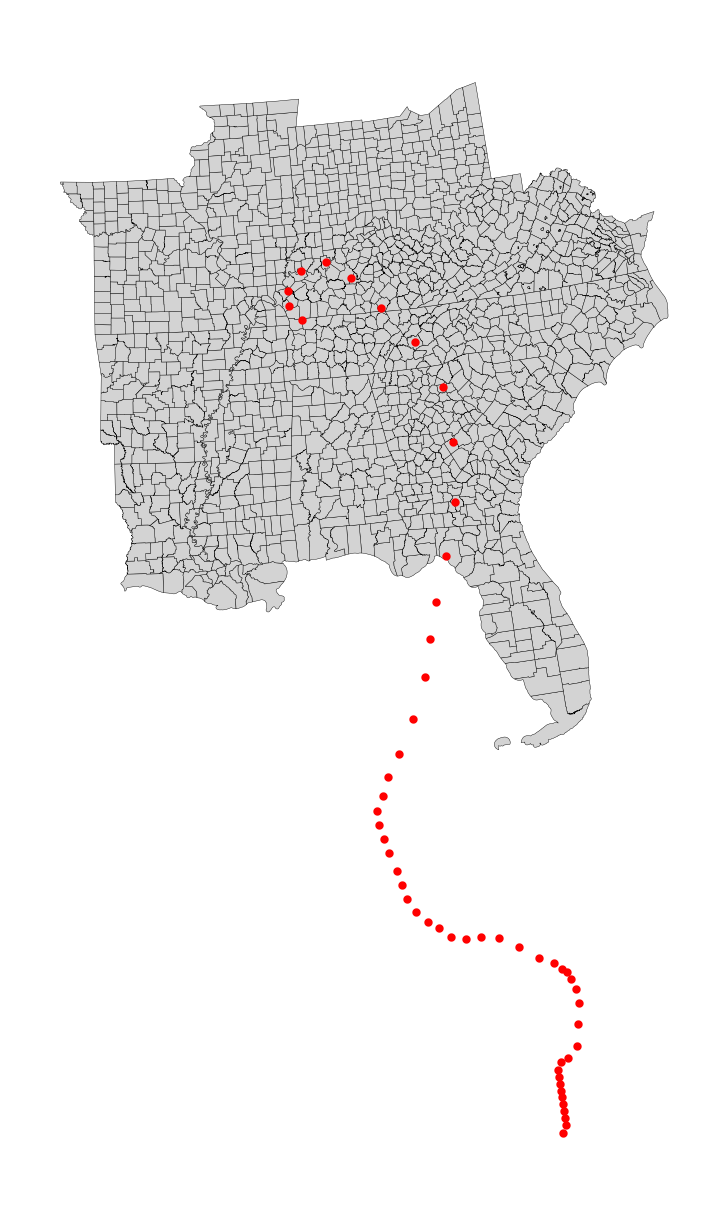

In [7]:
fig, ax = plt.subplots(figsize=(5, 5),dpi=300)

gdf_SE.plot(ax=ax, color='lightgray', edgecolor='black',lw=0.1)
storm_track.plot(ax=ax, color='red',markersize=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

In [8]:
gdf_SE_buffer = gdf_SE.copy()
gdf_SE_buffer["geometry"] = gdf_SE_buffer.geometry.buffer(12000)  # Buffer by 1 km
storm_track_on_land = gpd.sjoin(storm_track, gdf_SE_buffer, how="inner", predicate="intersects")

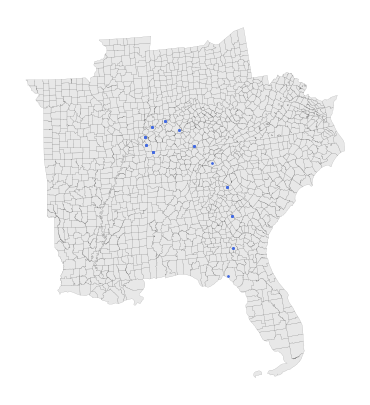

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))
gdf_SE.plot(ax=ax, color='lightgray', edgecolor='black',lw=0.1,alpha=0.5) # Plot land boundaries
storm_track_on_land.plot(ax=ax, color="royalblue", markersize=1)  # Plot points on land
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

33 hours of the storm were on the land

In [10]:
from shapely.geometry import LineString
# storm_track_on_land = storm_track_on_land.sort_values(by="time")
storm_line = LineString(storm_track_on_land.geometry.tolist())

no. selected counties 99
no. selected counties 133
no. selected counties 270
no. selected counties 487


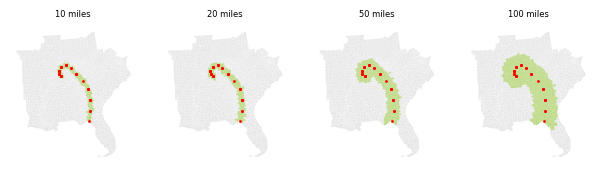

In [ ]:
from shapely.geometry import LineString
storm_line = LineString(storm_track_on_land.geometry.tolist())

mile_cutoff_ls = [10,50,100,200]  # 200 miles
fig, axs = plt.subplots(1, 4, figsize=(7.5, 2))
for idx,ax in enumerate(axs):
    mile_cutoff = mile_cutoff_ls[idx]
    buffer_distance = mile_cutoff * 1609.34  # 200 miles in meters
    # Step 1: Create a 200-mile buffer around the storm track
    # storm_buffer = storm_track_on_land.geometry.buffer(buffer_distance)
    storm_buffer = storm_line.buffer(buffer_distance)
    # Combine the buffered geometries into a single geometry
    # storm_buffer_union = storm_buffer.unary_union
    # Step 2: Find counties within the buffer
    counties_within_buffer = gdf_SE[gdf_SE.geometry.intersects(storm_buffer)]
    # Step 3: Extract county names or IDs

    county_list = counties_within_buffer['GEOID'].to_list()
    print('no. selected counties', len(county_list))
    ##Save list to a text file
    with open("../results/{}/counties_geoid_cut_{}.txt" .format(hurricane, mile_cutoff), "w") as f:
        for item in county_list:
            f.write(f"{item}\n")
    # Plot the results
    gdf_SE.plot(ax=ax, color="lightgrey", edgecolor="white",alpha=0.5,lw=0.2)  # Plot counties
    # storm_buffer.plot(ax=ax, color="green", alpha=0.3)
    gdf_SE[gdf_SE.geometry.intersects(storm_buffer)].plot(ax=ax, color="yellowgreen", edgecolor="None",alpha=0.5)  # Highlight selected counties
    storm_track_on_land.plot(ax=ax, color="red", markersize=1)  # Plot storm track
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title("{} miles".format(mile_cutoff),fontsize=6)
# plt.show()
# plt.savefig(f'../results/helene/storm_tracks.png', format = 'png',dpi=450,bbox_inches='tight',transparent=True)